In [306]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches
import tldextract #conda install -c conda-forge setuptools
from urllib.parse import urlparse

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

cuántas páginas (urls) distintas de ese dominio visitó cada usuario (device), para saber si una persona vio, por ej, 1 empleo,
o 10 empleos.   
Cuantas pageview tiene un usuario por dominio.   
En la MATRIZ quedaria algo asi:   
DEVICE | zonajobs.com.ar | quieroautis.com
661     0                  5
6412    12                 78
75      3                  0
9       99                 5

### **Lectura del Dataset - Datos demográficos de Género - Datos de URLS**

In [90]:
colnames = ['device_idx','label','feature_type','feature_detail', 'age']
df_analisis_exp = pd.read_csv('df_demografico_ar.csv', usecols=colnames)
df_analisis_exp = df_analisis_exp[(df_analisis_exp['feature_type']=='url')]

print('Tamaño del Dataset:',df_analisis_exp.shape)
print('\n')
print('Valores únicos en cada columna \n',df_analisis_exp.nunique())
print('Feauters type', df_analisis_exp['feature_type'].unique())
df_analisis_exp.head(3)

Tamaño del Dataset: (1576377, 5)


Valores únicos en cada columna 
 device_idx        98491
label                 2
feature_type          1
feature_detail    30882
age                   6
dtype: int64
Feauters type ['url']


,device_idx,label,feature_type,feature_detail,age
1,392.0,2.0,url,bumeran.com.ar/empleos-busqueda-legales.html,6.0
4,392.0,2.0,url,bumeran.com.ar/empleos/analista-de-legales-pas...,6.0
6,392.0,2.0,url,bumeran.com.ar/empleos-area-legales-busqueda-l...,6.0


Existen 1.576.377 filas con datos de sitios web o urls. Los cuales se reparten en 98.491 dispositivos únicos, que poseen datos de sitios web visitados.   
De estas 1.576.377 filas, 30.882 webpages son únicas. Las urls se repetirán por cada dispositivo que la visite.

In [91]:
#Dominios y ULRS: cuántas paginas visitó cada persona de ESE Dominio. Saber si la persona vio 1 empelo o 500 empleos por ej.
#Para esto ultimo, descargar el dataset incluyendo el feature type 'url'. Habra que separar el string dejando el dominio separado
#luego hacerlo coincidir con el feature dominio, y hacer la matriz de cant urls por dispositivo (fila) vs dom (col)
#Esto ultimo formaria parte del analisis de URLS

### **Valores Nulos**

In [92]:
print(df_analisis_exp.isnull().sum())

device_idx        0
label             0
feature_type      0
feature_detail    0
age               0
dtype: int64


No hay valores nulos en el dataset.

### **Valores duplicados**

In [93]:
pd.DataFrame(df_analisis_exp.groupby(['device_idx','feature_detail'])['feature_type'].count())\
                            .sort_values('feature_type', ascending=False)

feature_type
device_idx feature_detail                                                  
1.0        caras.perfil.com                                               1
67725.0    zonaprop.com.ar/departamentos-alquiler-nunez.html              1
67717.0    exitoina.perfil.com/noticias/destacada/estanisl...             1
           bumeran.com.ar/noticias                                        1
           bumeran.com.ar/login                                           1
...                                                                     ...
33631.0    jumbo.com.ar/congelados                                        1
           jumbo.com.ar/checkout/orderplaced                              1
           jumbo.com.ar/checkout                                          1
           jumbo.com.ar/cart                                              1
101989.0   zonajobs.com.ar/empleos/analista-de-cuentas-a-p...             1

[1576377 rows x 1 columns]

No hay valores duplicados.

### **Tratamiento de los datos**   
Dentro de la url, se separará por dominio, subdominio y sufijo para facilitar el análisis exploratorio y feature engineering.

In [94]:
df_url = df_analisis_exp.drop_duplicates(["feature_detail"])[["feature_detail"]] #quiero solo columna de urls, sin repetir
df_url = df_url.rename(columns={'feature_detail':'url'})

# parsea url
df_url['domain'] = df_url.url.apply(lambda u: tldextract.extract(u).domain)
df_url['subdomain'] = df_url.url.apply(lambda u: tldextract.extract(u).subdomain)
df_url['suffix'] =  df_url.url.apply(lambda u: tldextract.extract(u).suffix)
df_url['path'] =  df_url.url.apply(lambda u:urlparse(u).path)

def url_cleaner(url):
    up = urlparse(url)
    return up.netloc + up.path

df_url['url'] =  df_url.url.apply(url_cleaner)

df_url = df_url.drop_duplicates(["url"])
df_url

,url,domain,subdomain,suffix,path
1,bumeran.com.ar/empleos-busqueda-legales.html,bumeran,,com.ar,bumeran.com.ar/empleos-busqueda-legales.html
4,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran,,com.ar,bumeran.com.ar/empleos/analista-de-legales-pas...
6,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran,,com.ar,bumeran.com.ar/empleos-area-legales-busqueda-l...
8,bumeran.com.ar,bumeran,,com.ar,bumeran.com.ar
17,zonajobs.com.ar/candidatos/curriculum,zonajobs,,com.ar,zonajobs.com.ar/candidatos/curriculum
...,...,...,...,...,...
1245312,minutouno.com/notas/5159668-copa-maradona-boca...,minutouno,,com,minutouno.com/notas/5159668-copa-maradona-boca...
1299932,442.perfil.com/noticias/futbol/errores-y-desco...,perfil,442,com,442.perfil.com/noticias/futbol/errores-y-desco...
1330694,zonaprop.com.ar/propiedades/alquiler-departame...,zonaprop,,com.ar,zonaprop.com.ar/propiedades/alquiler-departame...
1381111,inmobiliariaparadela.com/alquiler,inmobiliariaparadela,,com,inmobiliariaparadela.com/alquiler


Se tokenizan y vectorian palabras en el path de la url

In [95]:
tokenizer = RegexpTokenizer("[a-z][a-z0-9]+")
sp_stop = set(stopwords.words('spanish'))
en_stop = set(stopwords.words('english'))
po_stop = set(stopwords.words('portuguese'))
stop_words = sp_stop.union(en_stop).union(po_stop)

df_url["path_corpus"] = (
    df_url
    .path
    .apply(lambda w: 
        " ".join([t for t in tokenizer.tokenize(w.lower().rsplit(".",1)[0]) if t not in stop_words])
    )
)

# vectoriza en presencia ausecia palabras
vectorizer_wc = CountVectorizer(min_df=30, binary=True)
X_doc = vectorizer_wc.fit_transform(df_url.path_corpus)
word_features = np.array(vectorizer_wc.get_feature_names())
df_url["path_vect"] = list(X_doc)

df_url.head(10)

,url,domain,subdomain,suffix,path,path_corpus,path_vect
1,bumeran.com.ar/empleos-busqueda-legales.html,bumeran,,com.ar,bumeran.com.ar/empleos-busqueda-legales.html,bumeran ar empleos busqueda legales,"(0, 81)\t1\n (0, 34)\t1\n (0, 206)\t1\n (..."
4,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran,,com.ar,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran ar empleos analista legales pasante fyo,"(0, 81)\t1\n (0, 34)\t1\n (0, 206)\t1\n (..."
6,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran,,com.ar,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran ar empleos area legales busqueda legales,"(0, 81)\t1\n (0, 34)\t1\n (0, 206)\t1\n (..."
8,bumeran.com.ar,bumeran,,com.ar,bumeran.com.ar,bumeran,"(0, 81)\t1"
17,zonajobs.com.ar/candidatos/curriculum,zonajobs,,com.ar,zonajobs.com.ar/candidatos/curriculum,zonajobs,"(0, 636)\t1"
18,zonajobs.com.ar/ofertas-de-empleo-argentina.html,zonajobs,,com.ar,zonajobs.com.ar/ofertas-de-empleo-argentina.html,zonajobs ar ofertas empleo argentina,"(0, 34)\t1\n (0, 636)\t1\n (0, 409)\t1\n ..."
19,zonajobs.com.ar,zonajobs,,com.ar,zonajobs.com.ar,zonajobs,"(0, 636)\t1"
21,bumeran.com.ar/empleos/chofer-de-reparto-carlo...,bumeran,,com.ar,bumeran.com.ar/empleos/chofer-de-reparto-carlo...,bumeran ar empleos chofer reparto carlos mainetti,"(0, 81)\t1\n (0, 34)\t1\n (0, 206)\t1\n (..."
22,zonajobs.com.ar/ofertas-de-trabajo-chofer-pagi...,zonajobs,,com.ar,zonajobs.com.ar/ofertas-de-trabajo-chofer-pagi...,zonajobs ar ofertas trabajo chofer pagina,"(0, 34)\t1\n (0, 636)\t1\n (0, 409)\t1\n ..."
23,veadigital.com.ar/landing/metodos-de-entrega,veadigital,,com.ar,veadigital.com.ar/landing/metodos-de-entrega,veadigital,"(0, 613)\t1"


In [96]:
print(df_url.isnull().sum())

url            0
domain         0
subdomain      0
suffix         0
path           0
path_corpus    0
path_vect      0
dtype: int64


In [97]:
print(df_url.iloc[2]['domain'])

#asi se ve el campo path_vect
print(df_url.iloc[2]['path_vect'])

bumeran
  (0, 81)	1
  (0, 34)	1
  (0, 206)	1
  (0, 85)	1
  (0, 328)	1
  (0, 35)	1


Tomo el domain y el path_corpus de cada url, y lo uno al dataset original.

In [98]:
df_url = df_url[['url','domain','path_corpus']]
print(df_url.shape)
df_url.head()

(30882, 3)


,url,domain,path_corpus
1,bumeran.com.ar/empleos-busqueda-legales.html,bumeran,bumeran ar empleos busqueda legales
4,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran,bumeran ar empleos analista legales pasante fyo
6,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran,bumeran ar empleos area legales busqueda legales
8,bumeran.com.ar,bumeran,bumeran
17,zonajobs.com.ar/candidatos/curriculum,zonajobs,zonajobs


In [99]:
df_analisis_exp = pd.merge(df_analisis_exp, df_url, how='left', left_on='feature_detail', right_on='url')
print(df_analisis_exp.shape)
df_analisis_exp

(1576377, 8)


,device_idx,label,feature_type,feature_detail,age,url,domain,path_corpus
0,392.0,2.0,url,bumeran.com.ar/empleos-busqueda-legales.html,6.0,bumeran.com.ar/empleos-busqueda-legales.html,bumeran,bumeran ar empleos busqueda legales
1,392.0,2.0,url,bumeran.com.ar/empleos/analista-de-legales-pas...,6.0,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran,bumeran ar empleos analista legales pasante fyo
2,392.0,2.0,url,bumeran.com.ar/empleos-area-legales-busqueda-l...,6.0,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran,bumeran ar empleos area legales busqueda legales
3,392.0,2.0,url,bumeran.com.ar,6.0,bumeran.com.ar,bumeran,bumeran
4,930.0,2.0,url,zonajobs.com.ar/candidatos/curriculum,5.0,zonajobs.com.ar/candidatos/curriculum,zonajobs,zonajobs
...,...,...,...,...,...,...,...,...
1576372,101820.0,2.0,url,gba.gob.ar/vivienda/requisitos_para_tener_una_...,5.0,gba.gob.ar/vivienda/requisitos_para_tener_una_...,gba,gba gob
1576373,101862.0,2.0,url,vix.com/es/ciencia/193546/antes-de-morir-astro...,5.0,vix.com/es/ciencia/193546/antes-de-morir-astro...,vix,vix
1576374,101862.0,2.0,url,creditosparatodos.org,5.0,creditosparatodos.org,creditosparatodos,creditosparatodos
1576375,101862.0,2.0,url,minutouno.com/notas/5157926-la-emocion-los-tri...,5.0,minutouno.com/notas/5157926-la-emocion-los-tri...,minutouno,minutouno


In [100]:
print(df_analisis_exp.isnull().sum()) #no fue posible corregir nulos de la manera anterior, puedo volver a intentar

device_idx          0
label               0
feature_type        0
feature_detail      0
age                 0
url               791
domain            791
path_corpus       791
dtype: int64


In [107]:
df_analisis_exp['domain'] = np.where((df_analisis_exp['domain'].isnull())&(df_analisis_exp['url'].str.contains(r"(zonajobs)")),
                                    'zonajobs', 
                                     np.where((df_analisis_exp['domain'].isnull())&(df_analisis_exp['url'].str.contains(r"(contextotucuman)")),
                                    'contextotucuman',df_analisis_exp['domain']))

df_analisis_exp['path_corpus'].fillna(df_analisis_exp['domain'],inplace=True) 
print(df_analisis_exp.isnull().sum()) 

device_idx          0
label               0
feature_type        0
feature_detail      0
age                 0
url                 0
domain             17
path_corpus       791
dtype: int64


In [108]:
df_analisis_exp[df_analisis_exp['domain'].isnull()] #ELIMINAR 

,device_idx,label,feature_type,feature_detail,age,url,domain,path_corpus
35909,101229.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,7.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
55100,43375.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,5.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
189127,90909.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,5.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
318492,87780.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,9.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
333140,67644.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,5.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
358966,50386.0,3.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,5.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
487414,30843.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,6.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
534797,54361.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,5.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
725832,23819.0,2.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,6.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN
859675,52136.0,3.0,url,sv4.tsnt.xyz:8080/upl17_2.m3u8,6.0,sv4.tsnt.xyz:8080/upl17_2.m3u8,NaN,NaN


In [111]:
df_analisis_exp.dropna(inplace=True)
print(df_analisis_exp.isnull().sum()) 

device_idx        0
label             0
feature_type      0
feature_detail    0
age               0
url               0
domain            0
path_corpus       0
dtype: int64


### Análisis descriptivo del feature type URLS + Feature Engineering

In [ ]:
df_analisis_exp.to_csv('urls_gender_analisis_exploratorio.csv')

In [312]:
data = df_analisis_exp.copy()
print(data.shape)
data.head()

(1576360, 8)


,device_idx,label,feature_type,feature_detail,age,url,domain,path_corpus
0,392.0,2.0,url,bumeran.com.ar/empleos-busqueda-legales.html,6.0,bumeran.com.ar/empleos-busqueda-legales.html,bumeran,bumeran ar empleos busqueda legales
1,392.0,2.0,url,bumeran.com.ar/empleos/analista-de-legales-pas...,6.0,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran,bumeran ar empleos analista legales pasante fyo
2,392.0,2.0,url,bumeran.com.ar/empleos-area-legales-busqueda-l...,6.0,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran,bumeran ar empleos area legales busqueda legales
3,392.0,2.0,url,bumeran.com.ar,6.0,bumeran.com.ar,bumeran,bumeran
4,930.0,2.0,url,zonajobs.com.ar/candidatos/curriculum,5.0,zonajobs.com.ar/candidatos/curriculum,zonajobs,zonajobs


In [313]:
print('Valores únicos en cada columna \n',data.nunique())

Valores únicos en cada columna 
 device_idx        98491
label                 2
feature_type          1
feature_detail    30881
age                   6
url               30881
domain              678
path_corpus       20912
dtype: int64


Con el tratamiento de datos realizado, puede verse que las 30.881 urls pertenecen a 678 dominios únicos.

**Distribución de dispositivos en Urls**

                             feature_detail  # Devices Unique
17814                       zonajobs.com.ar             20907
1817                         bumeran.com.ar             20092
1823        bumeran.com.ar/candidatos/carta             15458
17170                     veadigital.com.ar             14993
10588        disco.com.ar/comprar/home.aspx             14588
17174   veadigital.com.ar/comprar/home.aspx             14564
10605       disco.com.ar/login/prehome.aspx             14363
18311      zonajobs.com.ar/candidatos/carta             13705
8536                   bumeran.com.ar/login             13445
1826   bumeran.com.ar/candidatos/curriculum             13436

 Eje x: Cantidad de dispositivos únicos, Eje y: Cantidad de sitios web únicos


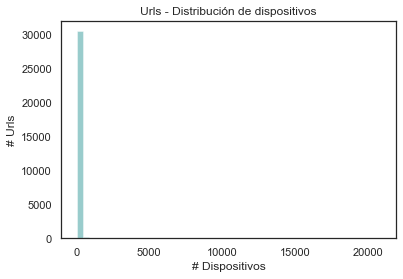

In [320]:
data_grafico = data[['device_idx','feature_detail']]
data_grafico = data_grafico.groupby(["feature_detail"]).nunique()
print(data_grafico.reset_index().sort_values('device_idx',ascending=False).rename(columns={'device_idx':
                                                                                          '# Devices Unique'}).head(10))
fig, ax = plt.subplots() 
#plt.figure(figsize=(10,8)) 
plt.title("Urls - Distribución de dispositivos")
# we can pass keyword arguments for each individual component of the plot
#We can pass in the variable we want to visualize along with keyword arguments for each of the individual
#components of the plot.
sns.distplot(data_grafico.reset_index().rename(columns={'device_idx':'# Devices Unique'})['# Devices Unique'], \
             kde=False, hist_kws={'color': 'Teal'});
plt.xlabel("# Dispositivos")
plt.ylabel("# Urls")
print('\n Eje x: Cantidad de dispositivos únicos, Eje y: Cantidad de sitios web únicos')
#ax.set(xlim=(0,20000))

[(0.0, 1000.0)]

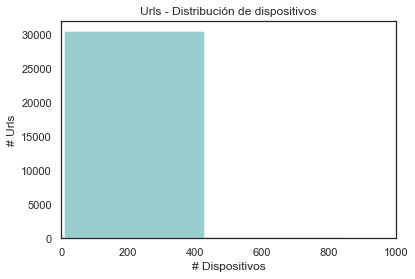

In [318]:
fig, ax = plt.subplots() 
#plt.figure(figsize=(10,6)) 
plt.title("Urls - Distribución de dispositivos")
# we can pass keyword arguments for each individual component of the plot
#We can pass in the variable we want to visualize along with keyword arguments for each of the individual
#components of the plot.
sns.distplot(data_grafico.reset_index().rename(columns={'device_idx':'# Devices Unique'})['# Devices Unique'], \
             kde=False, hist_kws={'color': 'Teal'});
plt.xlabel("# Dispositivos")
plt.ylabel("# Urls");
ax.set(xlim=(0,1000))

Más de 30.000 sitios web tienen visitas de entre 0 y 420 dispositivos aproximadamente. Es decir, pocos usuarios visitan muchos sitios distintos.     
Los sitios visitados por más de 500 dispositivos son muy pocos. Por lo que pocos sitios web o urls concentran a la mayor parte de la población de estudio. En otras palabras, muchos dispositivos visitan pocos sitios web específicos.

In [167]:
pd.options.display.max_rows = 20
print('Cantidad de dispositivos que visitan a cada url')
pd.DataFrame(data['feature_detail'].value_counts()).rename(columns={'feature_detail':'Devices'})

Cantidad de dispositivos que visitan a cada url


,Devices
zonajobs.com.ar,20907
bumeran.com.ar,20092
bumeran.com.ar/candidatos/carta,15458
veadigital.com.ar,14993
disco.com.ar/comprar/home.aspx,14588
...,...
vix.com/es/btg/musica/56100/29-canciones-en-espanol-que-son-cliche-del-karaoke-e-igual-seguiremos-cantando,8
miba.buenosaires.gob.ar/id/password/change,7
infobae.com,7
zonaprop.com.ar/inmobiliarias/paulet-propiedades_17103092-inmuebles.html,7


In [168]:
print('Porcentaje de Dispositivos únicos que visita a cada url')
pd.DataFrame(round(data.feature_detail.value_counts()/(data.device_idx.nunique())*100,2)).rename(columns={'feature_detail':
                                                                                                          'Devices'})

Porcentaje de Dispositivos únicos que visita a cada url


,Devices
zonajobs.com.ar,21.23
bumeran.com.ar,20.40
bumeran.com.ar/candidatos/carta,15.69
veadigital.com.ar,15.22
disco.com.ar/comprar/home.aspx,14.81
...,...
vix.com/es/btg/musica/56100/29-canciones-en-espanol-que-son-cliche-del-karaoke-e-igual-seguiremos-cantando,0.01
miba.buenosaires.gob.ar/id/password/change,0.01
infobae.com,0.01
zonaprop.com.ar/inmobiliarias/paulet-propiedades_17103092-inmuebles.html,0.01


En la tabla anterior se observa el porcentaje de dispositivos únicos que visitan a cada uno de los sitios web
21% de los dispositivos visita zonajobs.com.ar y casi el 20.5% de dispositivos visita bumeran.com.ar.

**Distribución de dispositivos en Dominios (sacados de las urls)**

          domain  # Devices Unique
80       bumeran             29778
78   buenosaires             27371
675     zonajobs             25166
676     zonaprop             16382
167        disco             16271
642   veadigital             15356
133     cronista             14318
405     movistar             11079
322        jumbo              8003
455       perfil              7374

 Eje x: Cantidad de dispositivos únicos, Eje y: Cantidad de domain únicos


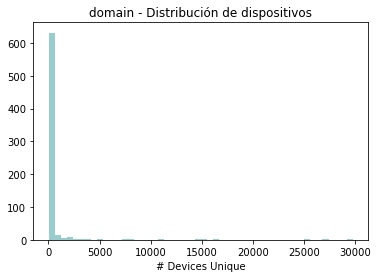

In [162]:
data_grafico = data[['device_idx','domain']]
data_grafico = data_grafico.groupby(["domain"]).nunique()
print(data_grafico.reset_index().sort_values('device_idx',ascending=False).rename(columns={'device_idx':
                                                                                          '# Devices Unique'}).head(10))
fig, ax = plt.subplots() 
#plt.figure(figsize=(10,8)) 
plt.title("domain - Distribución de dispositivos")
# we can pass keyword arguments for each individual component of the plot
#We can pass in the variable we want to visualize along with keyword arguments for each of the individual
#components of the plot.
sns.distplot(data_grafico.reset_index().rename(columns={'device_idx':'# Devices Unique'})['# Devices Unique'], \
             kde=False, hist_kws={'color': 'Teal'});
print('\n Eje x: Cantidad de dispositivos únicos, Eje y: Cantidad de domain únicos')
#ax.set(xlim=(0,20000))

[(0.0, 5000.0)]

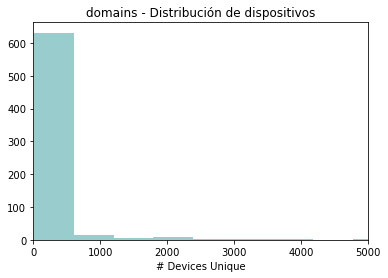

In [163]:
fig, ax = plt.subplots() 
#plt.figure(figsize=(10,6)) 
plt.title("domains - Distribución de dispositivos")
# we can pass keyword arguments for each individual component of the plot
#We can pass in the variable we want to visualize along with keyword arguments for each of the individual
#components of the plot.
sns.distplot(data_grafico.reset_index().rename(columns={'device_idx':'# Devices Unique'})['# Devices Unique'], \
             kde=False, hist_kws={'color': 'Teal'});
ax.set(xlim=(0,5000))

Más de 600 dominios tienen asociadas visitas de pocos usuarios.     
Pocos dominios concentran a la mayor parte de la población de estudio. Muchos dispositivos visitan pocos sitios web específicos.

In [247]:
#pd.options.display.max_rows = None
print('Cantidad de visitas a cada domain')
pd.DataFrame(data['domain'].value_counts()).rename(columns={'domain':'Visitas'})

Cantidad de visitas a cada domain


,Visitas
zonajobs,397118
bumeran,335541
zonaprop,155197
buenosaires,121626
disco,81444
...,...
guimatpropiedades,9
viajoentaxi,9
benditopie,9
soy502,8


In [248]:
#Agrupar en dominio: Otros aquellos con muy pocas cantidades de visitas.
#pd.options.display.max_rows = None
data2=pd.DataFrame(data['domain'].value_counts())
data2=data2['domain'].cumsum()/data.shape[0] #Cummulative Sum
data2

zonajobs             0.251921
bumeran              0.464779
zonaprop             0.563232
buenosaires          0.640388
disco                0.692054
                       ...   
guimatpropiedades    0.999979
viajoentaxi          0.999985
benditopie           0.999990
soy502               0.999996
infobae              1.000000
Name: domain, Length: 678, dtype: float64

In [249]:
print("Cummulative distribution of the top 1 of the domains with more devices (%): ",round(data2.iloc[0]*100,3))
print("Cummulative distribution of the top 5 of the domains with more devices (%): ",round(data2.iloc[4]*100,3))
print("Cummulative distribution of the top 10 of the domains with more devices (%): ",round(data2.iloc[9]*100,3))
print("Cummulative distribution of the top 15 of the domains with more devices (%): ",round(data2.iloc[14]*100,3))
print("Cummulative distribution of the top 20 of the domains with more devices (%): ",round(data2.iloc[19]*100,3))
print("Cummulative distribution of the top 25 of the domains with more devices (%): ",round(data2.iloc[24]*100,3))
print("Cummulative distribution of the top 30 of the domains with more devices (%): ",round(data2.iloc[29]*100,3))
print("Cummulative distribution of the top 35 of the domains with more devices (%): ",round(data2.iloc[34]*100,3))
print("Cummulative distribution of the top 40 of the domains with more devices (%): ",round(data2.iloc[39]*100,3))
print("Cummulative distribution of the top 45 of the domains with more devices (%): ",round(data2.iloc[44]*100,3))
print("Cummulative distribution of the top 50 of the domains with more devices (%): ",round(data2.iloc[49]*100,3))
print("Cummulative distribution of the top 55 of the domains with more devices (%): ",round(data2.iloc[54]*100,3))
print("Cummulative distribution of the top 60 of the domains with more devices (%): ",round(data2.iloc[59]*100,3))
print("Cummulative distribution of the top 65 of the domains with more devices (%): ",round(data2.iloc[64]*100,3))
print("Cummulative distribution of the top 70 of the domains with more devices (%): ",round(data2.iloc[69]*100,3))
print("Cummulative distribution of the top 75 of the domains with more devices (%): ",round(data2.iloc[74]*100,3))
print("Cummulative distribution of the top 80 of the domains with more devices (%): ",round(data2.iloc[79]*100,3))
print("Cummulative distribution of the top 85 of the domains with more devices (%): ",round(data2.iloc[84]*100,3))
print("Cummulative distribution of the top 90 of the domains with more devices (%): ",round(data2.iloc[89]*100,3))
print("Cummulative distribution of the top 95 of the domains with more devices (%): ",round(data2.iloc[94]*100,3))
print("Cummulative distribution of the top 100 of the domains with more devices (%): ",round(data2.iloc[99]*100,3))
print("Cummulative distribution of the top 110 of the domains with more devices (%): ",round(data2.iloc[109]*100,3))
print("Cummulative distribution of the top 120 of the domains with more devices (%): ",round(data2.iloc[119]*100,3))
print("Cummulative distribution of the top 150 of the domains with more devices (%): ",round(data2.iloc[149]*100,3))
print("Cummulative distribution of the top 200 of the domains with more devices (%): ",round(data2.iloc[199]*100,3))
print("Cummulative distribution of the top 250 of the domains with more devices (%): ",round(data2.iloc[249]*100,3))
print("Cummulative distribution of the top 300 of the domains with more devices (%): ",round(data2.iloc[299]*100,3))
print("Cummulative distribution of the top 350 of the domains with more devices (%): ",round(data2.iloc[349]*100,3))
print("Cummulative distribution of the top 400 of the domains with more devices (%): ",round(data2.iloc[399]*100,3))
print("Cummulative distribution of the top 450 of the domains with more devices (%): ",round(data2.iloc[449]*100,3))
print("Cummulative distribution of the top 500 of the domains with more devices (%): ",round(data2.iloc[499]*100,3))
print("Cummulative distribution of the top 550 of the domains with more devices (%): ",round(data2.iloc[549]*100,3))
print("Cummulative distribution of the top 600 of the domains with more devices (%): ",round(data2.iloc[599]*100,3))
print("Cummulative distribution of the top 650 of the domains with more devices (%): ",round(data2.iloc[649]*100,3))
print("Cummulative distribution of the top 678 (the end) of the domains with more devices (%): ",round(data2.iloc[677]*100,3))

Cummulative distribution of the top 1 of the domains with more devices (%):  25.192
Cummulative distribution of the top 5 of the domains with more devices (%):  69.205
Cummulative distribution of the top 10 of the domains with more devices (%):  84.117
Cummulative distribution of the top 15 of the domains with more devices (%):  87.981
Cummulative distribution of the top 20 of the domains with more devices (%):  90.242
Cummulative distribution of the top 25 of the domains with more devices (%):  91.809
Cummulative distribution of the top 30 of the domains with more devices (%):  93.181
Cummulative distribution of the top 35 of the domains with more devices (%):  94.387
Cummulative distribution of the top 40 of the domains with more devices (%):  95.354
Cummulative distribution of the top 45 of the domains with more devices (%):  96.029
Cummulative distribution of the top 50 of the domains with more devices (%):  96.545
Cummulative distribution of the top 55 of the domains with more dev

In [250]:
data2.reset_index().iloc[59] #A partir de este dominio, la cantidad de dispositivos se suma marginalmente

index     empleosit
domain     0.972264
Name: 59, dtype: object

In [251]:
temporal = pd.DataFrame(round(data['domain'].value_counts()/data['device_idx'].nunique()*100,2)).reset_index()
dispositivo_umbral = temporal.reset_index().iloc[59]['domain']

lista_dominios_relevantes = []
for feature_detail, row in temporal.iterrows():
    if float(row['domain']) >= dispositivo_umbral:
        lista_dominios_relevantes.append(str(row['index']))
lista_dominios_relevantes 

['zonajobs',
 'bumeran',
 'zonaprop',
 'buenosaires',
 'disco',
 'veadigital',
 'jumbo',
 'movistar',
 'cronista',
 'perfil',
 'minutouno',
 'futbollibre',
 'solodeportes',
 'eldia',
 'almundo',
 'gba',
 'ypf',
 'prestamosparatodos',
 'toyota',
 'pronto',
 '0221',
 'tuenti',
 'contextotucuman',
 'ausa',
 'sancorsalud',
 'animeflv',
 'ambito',
 'creditosparatodos',
 'infotechnology',
 'diarioregistrado',
 'coppel',
 'sommiercenter',
 'renault',
 'losandes',
 'depor',
 'ratingcero',
 'autocosmos',
 'lacapitalmdp',
 'supermercadosdia',
 'itau',
 'televisionlibre',
 'nissan',
 '21',
 'credicuotas',
 'starbucksrewards',
 'veraz',
 'jetsmart',
 'vicentelopez',
 'elcomercio',
 'curriculumvitaeempresarial',
 'planrombo',
 'mundoazulgrana',
 'philips',
 'rojadirectatv',
 'gardenlife',
 'credisense',
 'elbocon',
 'laserenisimavaatucasa',
 'swarovski',
 'empleosit']

In [252]:
#New temporal variable
data['domain_2']=np.where(data['domain'].isin(lista_dominios_relevantes),data.domain,'Otros')
data = data.drop('domain', axis=1)
#Replacement of the original variable
data = data.rename(columns={'domain_2':'domain'})
print(data.shape)
data.head()

(1576360, 8)


,device_idx,label,feature_type,feature_detail,age,url,path_corpus,domain
0,392.0,2.0,url,bumeran.com.ar/empleos-busqueda-legales.html,6.0,bumeran.com.ar/empleos-busqueda-legales.html,bumeran ar empleos busqueda legales,bumeran
1,392.0,2.0,url,bumeran.com.ar/empleos/analista-de-legales-pas...,6.0,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran ar empleos analista legales pasante fyo,bumeran
2,392.0,2.0,url,bumeran.com.ar/empleos-area-legales-busqueda-l...,6.0,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran ar empleos area legales busqueda legales,bumeran
3,392.0,2.0,url,bumeran.com.ar,6.0,bumeran.com.ar,bumeran,bumeran
4,930.0,2.0,url,zonajobs.com.ar/candidatos/curriculum,5.0,zonajobs.com.ar/candidatos/curriculum,zonajobs,zonajobs


In [253]:
print('Cantidad de visitas a cada dominio, con variable dominios agrupada')
pd.DataFrame(data['domain'].value_counts()).rename(columns={'domain':'Visitas'})

Cantidad de visitas a cada dominio, con variable dominios agrupada


,Visitas
zonajobs,397118
bumeran,335541
zonaprop,155197
buenosaires,121626
disco,81444
...,...
credisense,928
elbocon,922
laserenisimavaatucasa,878
swarovski,801


In [ ]:
#grafico de lo anterior

### Matriz Device - Dominio (cantidad de visitas)

In [254]:
#generar la matriz device y dominios con cantidad de visitas de ese device en ese dominio. Luego le uno el genero
pd.options.display.max_columns = None #veo todas las columnas
data_domains = data.groupby(['device_idx','domain']).count()[['feature_type']].reset_index()
data_domains = pd.pivot_table(data_domains, values='feature_type', index=['device_idx'],
                                columns=['domain'], aggfunc=np.sum).fillna(0)
data_domains = data_domains.reset_index()
data_domains

domain,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98486,101985.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98487,101986.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98488,101987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98489,101988.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


In [255]:
#Probando si funciona bien
data_domains[data_domains['device_idx']==22186.0]

domain,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop
21411,22186.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,16.0,71.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,649.0,6.0


In [236]:
data.columns

Index(['device_idx', 'label', 'feature_type', 'feature_detail', 'age', 'url',
       'path_corpus', 'domain'],
      dtype='object')

In [1]:
#Uno el género
data_final = data[['device_idx','label']]
data_final = data_final.drop_duplicates('device_idx',keep='first')

df_final = pd.merge(data_domains, data_final, how='left', on='device_idx')


In [296]:
100*pd.value_counts(df_final.label)/df_final.shape[0]

3.0    52.993675
2.0    47.006325
Name: label, dtype: float64

El dataset cuenta con 53% de usuarios femeninos y 47% de usuarios masculinos.

### Analisis descriptivo de los dominios vs genero - bivariado

**Wordclouds**

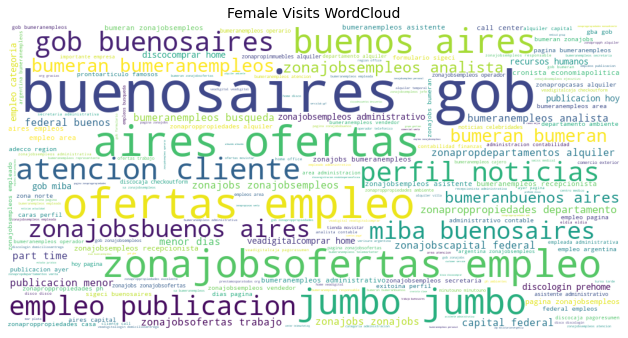

In [146]:
#WORDCLOUD
words_fem = data[(data['label']==3)]
my_list = words_fem['path_corpus'].to_list() 
# new_list=[]
# for sentence in my_list:
#     if 'ar' not in sentence:
#         new_list.append(sentence)
# my_list = new_list
#convert list to string and generate
unique_string=(" ").join(my_list)
unique_string=unique_string.replace(' ar ','')
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(11,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Female Visits WordCloud", fontsize=14)
plt.show()

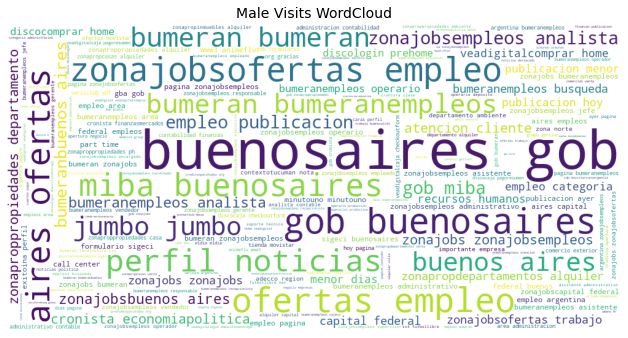

In [147]:
#WORDCLOUD
words_fem = data[(data['label']==2)]
my_list = words_fem['path_corpus'].to_list() 
# new_list=[]
# for sentence in my_list:
#     if 'ar' not in sentence:
#         new_list.append(sentence)
# my_list = new_list
#convert list to string and generate
unique_string=(" ").join(my_list)
unique_string=unique_string.replace(' ar ','')
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(11,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Male Visits WordCloud", fontsize=14)
plt.show()

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#

**Barras (proporción) y Distribución**

In [258]:
pd.set_option("display.max_rows", 50)
data_dom = data[['device_idx','label','feature_detail','domain']]
data_dom

,device_idx,label,feature_detail,domain
0,392.0,2.0,bumeran.com.ar/empleos-busqueda-legales.html,bumeran
1,392.0,2.0,bumeran.com.ar/empleos/analista-de-legales-pas...,bumeran
2,392.0,2.0,bumeran.com.ar/empleos-area-legales-busqueda-l...,bumeran
3,392.0,2.0,bumeran.com.ar,bumeran
4,930.0,2.0,zonajobs.com.ar/candidatos/curriculum,zonajobs
...,...,...,...,...
1576372,101820.0,2.0,gba.gob.ar/vivienda/requisitos_para_tener_una_...,gba
1576373,101862.0,2.0,vix.com/es/ciencia/193546/antes-de-morir-astro...,Otros
1576374,101862.0,2.0,creditosparatodos.org,creditosparatodos
1576375,101862.0,2.0,minutouno.com/notas/5157926-la-emocion-los-tri...,minutouno


Dominio y % Dispositivos por Género


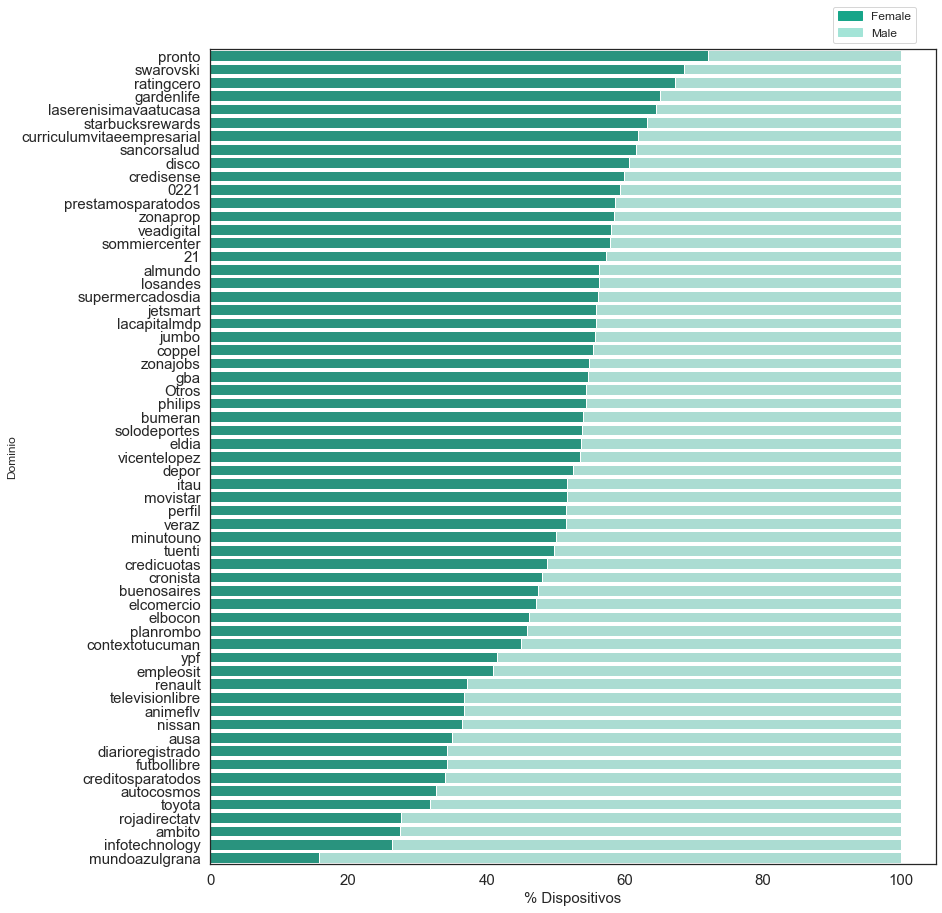

In [321]:
df = data_dom.copy()
print('Dominio y % Dispositivos por Género')
## load dataset
tips = df.copy()

# set the figure size
plt.figure(figsize=(13, 15))

# from raw value to percentage
total = tips.groupby('domain')['device_idx'].agg(['nunique']).reset_index()
female = tips[tips.label==3].groupby('domain')['device_idx'].agg(['nunique']).reset_index()
female['nunique'] = [i / j * 100 for i,j in zip(female['nunique'], total['nunique'])]
total['nunique'] = [i / j * 100 for i,j in zip(total['nunique'], total['nunique'])]
total = total.sort_values('nunique', ascending=False)
female = female.sort_values('nunique', ascending=False)

# bar chart 1 -> top bars (group of 'Male')
bar1 = sns.barplot(x="nunique",  y="domain", data=total, color='#A3E4D7')

# bar chart 2 -> bottom bars (group of 'Female')
bar2 = sns.barplot(x="nunique", y="domain", data=female, color='#17A589')

# add legend 
top_bar = mpatches.Patch(color='#17A589', label='Female')
bottom_bar = mpatches.Patch(color='#A3E4D7', label='Male')
plt.legend(handles=[top_bar, bottom_bar], loc='left', bbox_to_anchor=(0.85,1.0), fontsize=12)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=15)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(15)
    
plt.xlabel("% Dispositivos")
plt.ylabel("Dominio")

# show the graph
plt.show()

La nueva variable que agrupa por dominios a los sitios web visitados presenta variabilidad con el género.   
Los sitios de farnandula como "pronto" y "ratingcero", y los sitios de marcas como "swarovsky" y "starbucks rewards", asi como también sitios de jardinería y alimentos tienen una marcada predisposición hacia el género femenino mas que al masculino.   
En cambio, sitios sobre deporte como "mundoazulgrana", "rojadirectatv" y "futbollibre" entre otros, más sitios sobre tecnología y atuos son visitados más por el género masculino que femenino.   

In [269]:
print('Sitios más visitados por el género Femenino')
visitas_fem = pd.DataFrame(data[data['label']==3]['domain'].value_counts()).rename(columns={'domain':'Visitas'})
visitas_fem

Sitios más visitados por el género Femenino


,Visitas
zonajobs,234289
bumeran,191383
zonaprop,94401
buenosaires,58888
disco,50207
...,...
credisense,555
elbocon,417
rojadirectatv,344
empleosit,267


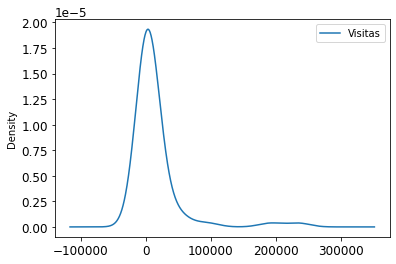

In [276]:
visitas_fem.plot.kde();

In [278]:
print('Sitios más visitados por el género Masculino')
visitas_masc = pd.DataFrame(data[data['label']==2]['domain'].value_counts()).rename(columns={'domain':'Visitas'})
visitas_masc

Sitios más visitados por el género Masculino


,Visitas
zonajobs,162829
bumeran,144158
buenosaires,62738
zonaprop,60796
disco,31237
...,...
empleosit,467
credisense,373
gardenlife,345
laserenisimavaatucasa,257


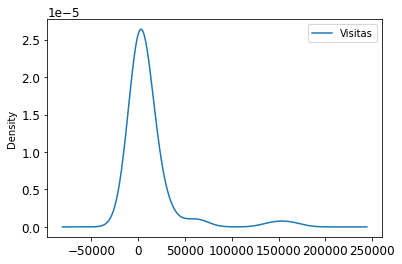

In [279]:
visitas_masc.plot.kde();

Distribución de visitas por dominio de Sitio Web


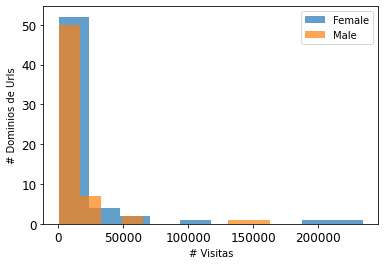

In [283]:
print('Distribución de visitas por dominio de Sitio Web')
plt.figure() #histogramas
# plot a kernel density estimation over a stacked barchart
v1=visitas_fem['Visitas']
v2=visitas_masc['Visitas']
plt.hist(v1, alpha=0.7, label='Female'); #desde -50 a 150, de 5 en 5
plt.hist(v2, alpha=0.7, label='Male');
plt.legend()
plt.xlabel("# Visitas")
plt.ylabel("# Dominios de Urls");

### **Procesamiento de los datos para incluir en modelos**

In [287]:
print(df.shape)
df_final.head()

(1576360, 5)


,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0


In [332]:
df_final.tail(30)

,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop,fem
98461,101959.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0
98462,101960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.0,1
98463,101961.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
98464,101962.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
98465,101963.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,17.0,1
98466,101964.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0
98467,101965.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0
98468,101966.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
98469,101967.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
98470,101968.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,0.0,1


In [297]:
#genero variable binaria 1 y 0
df_final['fem']=np.where(df_final.label==3,1,0)
print(100*pd.value_counts(df_final.fem)/df_final.shape[0])
df_final = df_final.drop('label', axis=1)
df_final.head(3)

1    52.993675
0    47.006325
Name: fem, dtype: float64


,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop,fem
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [298]:
y = df_final[['device_idx','fem']]
y = y.dropna()
y=y.sort_values('device_idx')
print(y.shape)
y.head()

(98491, 2)


,device_idx,fem
0,1.0,1
1,2.0,0
2,3.0,0
3,4.0,0
4,5.0,0


In [299]:
y.tail()

,device_idx,fem
98486,101985.0,0
98487,101986.0,1
98488,101987.0,0
98489,101988.0,0
98490,101989.0,1


In [300]:
print(df_final.shape)
pd.options.display.max_rows = None 
print(df_final.isnull().sum())

(98491, 63)
device_idx                    0
0221                          0
21                            0
Otros                         0
almundo                       0
ambito                        0
animeflv                      0
ausa                          0
autocosmos                    0
buenosaires                   0
bumeran                       0
contextotucuman               0
coppel                        0
credicuotas                   0
credisense                    0
creditosparatodos             0
cronista                      0
curriculumvitaeempresarial    0
depor                         0
diarioregistrado              0
disco                         0
elbocon                       0
elcomercio                    0
eldia                         0
empleosit                     0
futbollibre                   0
gardenlife                    0
gba                           0
infotechnology                0
itau                          0
jetsmart                    

**Correlation Plot between independent variables**

In [304]:
variables_dep = []
for col in df_final.columns:
    if col != 'fem': 
        if col != 'device_idx':
            variables_dep.append(col)        

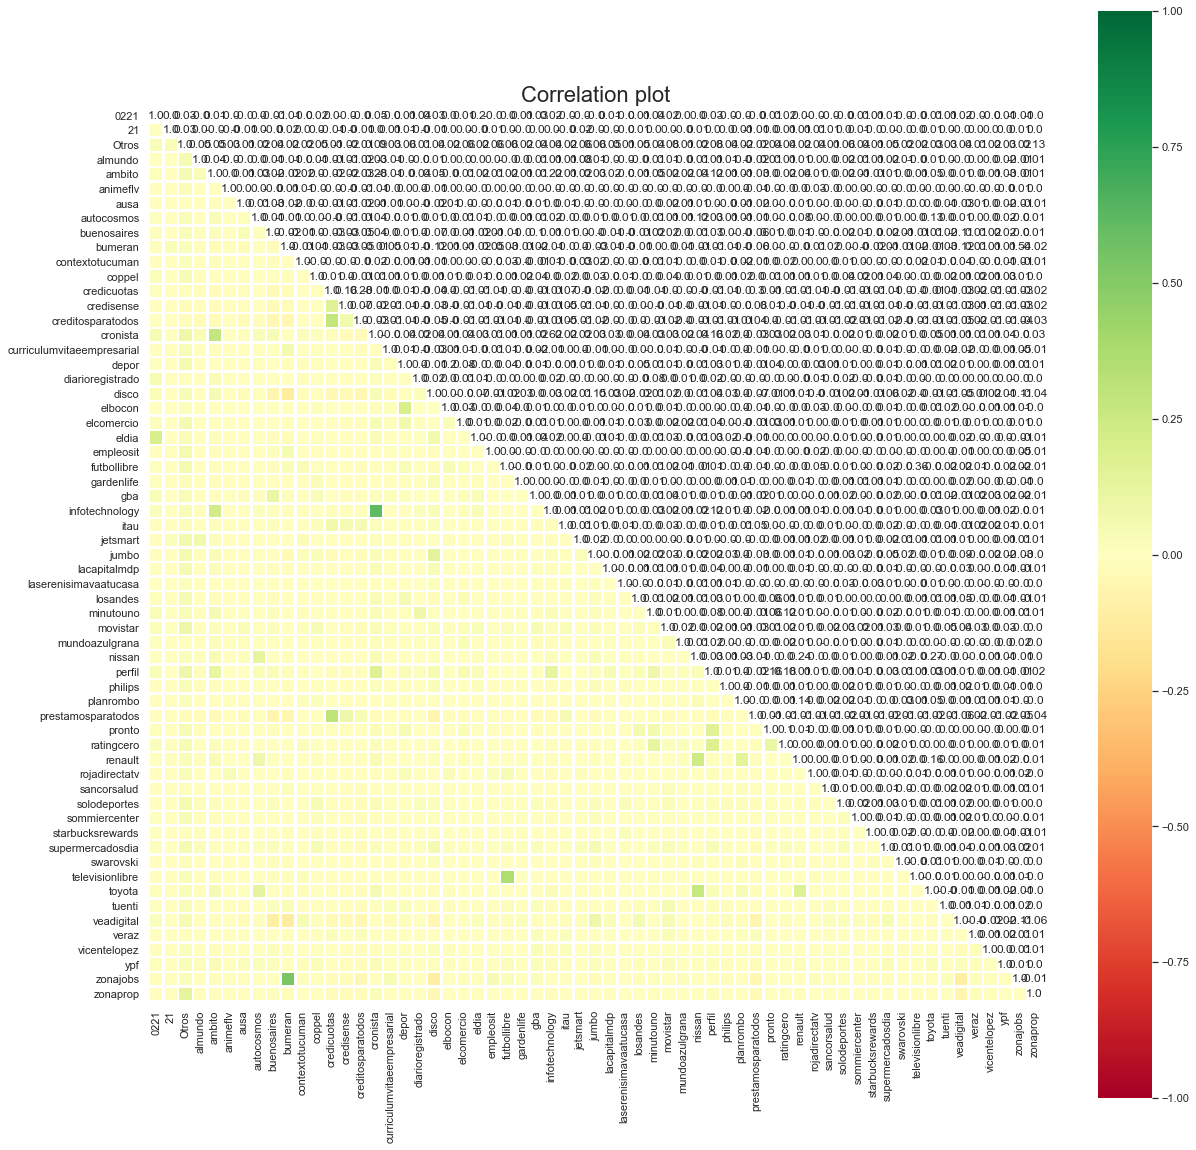

In [308]:
data = df_final[variables_dep] #se toman solo variables numéricas

sns.set(style="white")
fig, ax = plt.subplots(1, figsize=(20, 20))
corr = data.corr()
labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.round(2)
labels = labels.replace(np.nan, ' ', regex=True)

mask = np.triu(np.ones(corr.shape)).astype(np.bool)
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='RdYlGn',
    fmt='',
    square=True,
    linewidths=1.5).set_title("Correlation plot", fontsize=22)
mask = np.ones(corr.shape) - mask
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=ListedColormap(['white']),
    annot=labels,
    cbar=False,
    fmt='',
    linewidths=1.5)

Se ve correlación positivia entre algunos sitios como bumeran y zonajobs, lo cual hace sentido ya que ambos son de empleo. En general, quien busca en zoanjobs, también busca en bumeran.   
También se observa correlación positiva entre infotechnology y el sitio de noticas cronista, entre futbollibre y televisionlibre.   
Sitios de toyota y nissan también presentan correlación positiva, lo cual tiene lógica por pertenecer ambos a un rubro de automóviles.

**Variance Inflation Factor (VIF)**

In [310]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

  
# the independent variables set (solo numericas, por eso hago acá la transformacion a dummies)
X = df_final[variables_dep]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                       feature       VIF
0                         0221  1.052741
1                           21  1.004955
2                        Otros  1.227876
3                      almundo  1.024104
4                       ambito  1.146319
5                     animeflv  1.003815
6                         ausa  1.010962
7                   autocosmos  1.034584
8                  buenosaires  1.093913
9                      bumeran  1.532709
10             contextotucuman  1.007509
11                      coppel  1.018772
12                 credicuotas  1.241537
13                  credisense  1.033956
14           creditosparatodos  1.102535
15                    cronista  1.796640
16  curriculumvitaeempresarial  1.011364
17                       depor  1.070178
18            diarioregistrado  1.011342
19                       disco  1.108281
20                     elbocon  1.048918
21                  elcomercio  1.021885
22                       eldia  1.054173
23              

In [311]:
pd.options.display.max_rows = None
vif_data.sort_values('VIF',ascending=False)

,feature,VIF
15,cronista,1.796640
27,infotechnology,1.643711
9,bumeran,1.532709
59,zonajobs,1.522171
12,credicuotas,1.241537
2,Otros,1.227876
24,futbollibre,1.191079
52,televisionlibre,1.158773
4,ambito,1.146319
37,nissan,1.141372


Puede verse que las variables mas "infladas" son los sitios de cronista, infotechnology, bumeran y zonajobs.   
Sin embargo, su VIF no e slo sificientemente alto como para decidir quitar esas variables al momento de modelar.

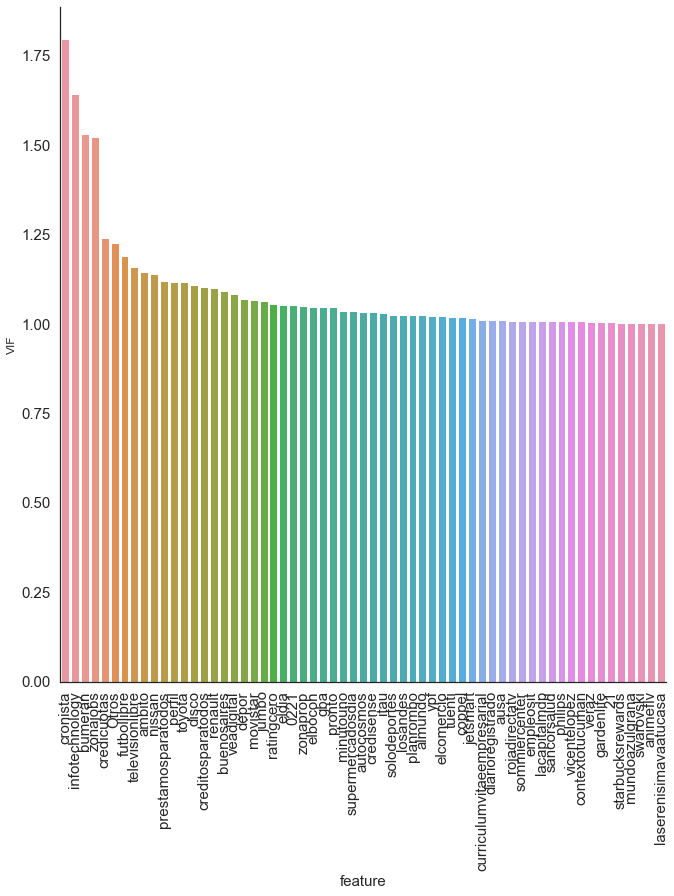

In [330]:
df_barplot = vif_data.copy().sort_values('VIF',ascending=False)
sns.catplot(x='feature',y='VIF',data=df_barplot,kind='bar',height=10, aspect=1)
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=15)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(15)
plt.show()

In [301]:
df_final.to_csv('df_final_urls.csv')